In [11]:
import torch

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print('total: {:}\nreserved: {:}\nallocated: {:}\nfree: {:}'.format(t/1e9,r/1e9,a/1e9,f/1e9))

total: 4.294967296
reserved: 2.367684608
allocated: 0.290009088
free: 2.07767552


In [29]:
import pickle

para = 'Nback'

# Load meta dict

with open('../../AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../../BrainAgePredictWrat/' + para + 'Only10FoldSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['cand' + para + 'YesWrat']
    groups = splits['groups']
    
print(len(subids))

846


In [30]:
# Load WRAT for subjects

import numpy as np

idWratDict = {}

with open('../../wrat.csv') as f:
    for line in f.readlines()[1:]:
        parts = line.split(',')
        try:
            idWratDict[int(parts[0])] = int(parts[3])
        except Exception as e:
            print(parts[0])
            print(e)
            
wrat = np.array([idWratDict[subid] for subid in subids])

print(wrat.shape)
print('Complete')

603056110671
invalid literal for int() with base 10: 'NaN\n'
603317055381
invalid literal for int() with base 10: 'NaN\n'
604847970437
invalid literal for int() with base 10: 'NaN\n'
(846,)
Complete


In [31]:
import numpy as np

paradigm = 'nback'
subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

all_ts = [loadSeries('../..', paradigm, meta[subid][paradigm]) for subid in subidsNp]

print('Loading complete')

Loading complete


In [32]:
# Normalize timeseries

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print('nan {:}'.format(i))
        if np.sum(np.isinf(subj)) > 0:
            print('inf {:}'.format(i))
            
normalizeSubjects(all_ts)

print('Complete')

Complete


In [27]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
X_all = np.vstack(X_all)

print(X_all[10:20])
print('Complete')

[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [35]:
print(all_ts[0].shape)
print(len(all_ts))

(264, 231)
846


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nRoi = 264
nt = all_ts[0].shape[1]

class Trans(nn.Module):
    def __init__(self):
        super(Trans, self).__init__()
        self.trans = nn.Transformer(d_model=nRoi, nhead=8, 
                                    num_encoder_layers=2, num_decoder_layers=2, 
                                    dim_feedforward=100, dropout=0.1).cuda()
        self.fc1 = nn.Linear(264,50).cuda()
        self.fc2 = nn.Linear(50,1).cuda()
        
    def forward(self, x):
        nB = x.shape[0]
        x = torch.cat([x, torch.ones(nB, nRoi, 1).cuda()], dim=2)
        x = x.permute(2,0,1)
        x = self.trans(x,x)#,src_mask=mask,tgt_mask=mask)
        x = x[nt,:,:]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

all_ts_t = torch.from_numpy(np.stack(all_ts)).float()
agesPredTrans = torch.zeros(all_ts_t.shape[0])
# mask = (torch.arange(0,232).float().unsqueeze(1)@torch.ones(1,232)).cuda()

import random

# Loop over splits 
splitIdx = 0
for trainIdcs, testIdcs in groups:
    trans = Trans()
    optim = torch.optim.Adam(trans.parameters(), lr=2e-4)

    train_ts = all_ts_t[trainIdcs].cuda()
    test_ts = all_ts_t[testIdcs]

#     X_train = X_all[trainIdcs,0]
    X_train = wrat[trainIdcs]

    running = 0
    nEpoch = 3500
    pPeriod = 100
    nB = 10
    N = train_ts.shape[0]

    for epoch in range(nEpoch):
        batch = []
        truth = torch.zeros(nB).float().cuda()
        for i in range(nB):
            idx = random.randint(0,N-1)
            batch.append(train_ts[idx])
            truth[i] = X_train[idx]
        batch = torch.stack(batch)
        optim.zero_grad()
        pred = trans(batch).flatten()
        loss = torch.sum((pred-truth)**2)
        loss.backward()
        running += loss.detach().cpu()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpoch-1:
            if epoch != 0:
                if epoch % pPeriod != 0:
                    running /= epoch % pPeriod
                else:
                    running /= pPeriod
            print('epoch {:d} loss={:f}'.format(epoch, ((running/nB)**0.5)/12))
            running = 0

    print('Finished training')
    
    for i in range(int(test_ts.shape[0]/10)+1):
        st = i*10
        end = st+10
        if st >= test_ts.shape[0]:
            break
        if end > test_ts.shape[0]:
            end = test_ts.shape[0]
        test_ts_b = test_ts[st:end].cuda()
        agesPredTrans[testIdcs[st:end]] = trans(test_ts_b).flatten().detach().cpu()
    
    print('Completed split {:}'.format(splitIdx))
    splitIdx += 1

print('All complete')

epoch 0 loss=9.167953
epoch 100 loss=8.098395
epoch 200 loss=6.765465
epoch 300 loss=4.446631
epoch 400 loss=2.339750
epoch 500 loss=1.424108
epoch 600 loss=1.251664
epoch 700 loss=1.307113
epoch 800 loss=1.295481
epoch 900 loss=1.224435
epoch 1000 loss=1.255258
epoch 1100 loss=1.179757
epoch 1200 loss=1.124896
epoch 1300 loss=1.011920
epoch 1400 loss=0.938677
epoch 1500 loss=0.758009
epoch 1600 loss=0.689453
epoch 1700 loss=0.544296
epoch 1800 loss=0.505308
epoch 1900 loss=0.439458
epoch 2000 loss=0.392188
epoch 2100 loss=0.334052
epoch 2200 loss=0.301783
epoch 2300 loss=0.267788
epoch 2400 loss=0.276206
epoch 2499 loss=0.237123
Finished training
Completed split 0
epoch 0 loss=9.068337
epoch 100 loss=8.012454
epoch 200 loss=6.378668
epoch 300 loss=4.101696
epoch 400 loss=2.146854
epoch 500 loss=1.393782
epoch 600 loss=1.290004
epoch 700 loss=1.290726
epoch 800 loss=1.295482
epoch 900 loss=1.291989
epoch 1000 loss=1.203793
epoch 1100 loss=1.145083
epoch 1200 loss=1.133049
epoch 1300 lo

[[1.         0.18258598]
 [0.18258598 1.        ]]
16.987509683957192
13.270189163532663


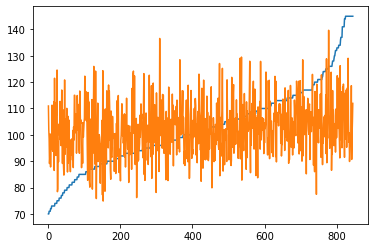

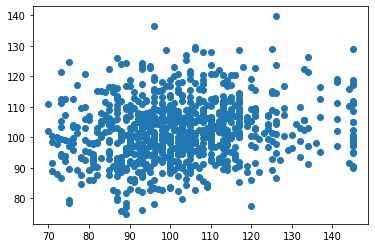

In [41]:
import matplotlib.pyplot as plt

# test_labels = X_all[:,0]
test_labels = wrat
predY = agesPredTrans.detach().cpu().numpy()
# test_labels = X_all[testIdcs,0]
# predY = trans(test_ts).flatten().detach().cpu().numpy()

idcs = np.argsort(test_labels[:])
yPred = predY[idcs]
y = test_labels[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5
mae = np.sum(np.abs(y-yPred))/len(y)
# rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
# mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [38]:
# Save predictions

with open('../../../BrainAgePredictWrat/Wrat/TransformerWratNbackPredictions.bin', 'wb') as f:
    pickle.dump(agesPredTrans.detach().cpu().numpy(), f)
    
print('Complete')

Complete


In [39]:
# Check predictions

with open('../../../BrainAgePredictWrat/Wrat/TransformerWratNbackPredictions.bin', 'rb') as f:
    check = pickle.load(f)
    
print(check[0:10])
print(agesPredTrans[0:10])
print(np.count_nonzero(check == agesPredTrans.detach().cpu().numpy()))
print(check.shape[0])

[106.76784  114.45502  106.76398   89.592155  98.077415 107.44032
  98.620415  95.74305  110.79146   91.66302 ]
tensor([106.7678, 114.4550, 106.7640,  89.5922,  98.0774, 107.4403,  98.6204,
         95.7430, 110.7915,  91.6630])
846
846
